<a href="https://colab.research.google.com/github/uwsampl/tutorial/blob/master/notebook/06_TVM_Tutorial_MicroTVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please run the following block to ensure TVM is setup for *this notebook*.  Each notebook may have its own runtime.

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    ! gsutil cp "gs://tvm-fcrc-binariesd5fce43e-8373-11e9-bfb6-0242ac1c0002/tvm.tar.gz" /tmp/tvm.tar.gz
    ! mkdir -p /tvm
    ! tar -xf /tmp/tvm.tar.gz --strip-components=4 --directory /tvm
    ! ls -la /tvm
    ! bash /tvm/package.sh
    # Add TVM to the Python path.
    import sys
    sys.path.append('/tvm/python')
    sys.path.append('/tvm/topi/python')
    ! pip install mxnet
else:
    print('Notebook executing locally, skipping Colab setup ...')

Copying gs://tvm-fcrc-binariesd5fce43e-8373-11e9-bfb6-0242ac1c0002/tvm.tar.gz...
- [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objects/119.5 MiB.                                    
total 164
drwxr-xr-x 21 root root  4096 Jun 21 02:52 .
drwxr-xr-x  1 root root  4096 Jun 21 02:49 ..
drwx------  8 root root  4096 May 31 08:14 3rdparty
drwx------ 12 root root  4096 May 31 08:14 apps
drwx------  3 root root  4096 Jun 19 07:58 build
drwx------  4 root root  4096 May 31 08:14 cmake
-rw-------  1 root root 11053 Jun 19 04:54 CMakeLists.txt
drwx------  6 root root  4096 May 31 08:14 conda
-rw-------  1 root root  5736 Jun 19 04:54 CONTRIBUTORS.md
drwx------  3 root root  4096 May 31 08:14 docker
drwx------ 11 root root  4096 May 31 08:14 docs
drwx------  4 root root  4096 May 31 08:14 golang
drwx------  3 root root  4096 May 31 08:14 include
-rw-------  1 root root 10607 Jun 19 04:54 Jenkinsfile
drwx------  6 root root  4096 May 31 

# μTVM
The proliferation of low-cost, AI-powered consumer devices has lead to widespread interest in "bare-metal" (low-power, often without an operating system) devices among ML researchers and practitioners.

μTVM brings deep learning code generated by TVM to bare-metal devices that lack mature software stacks or do not have an operating system. Here's a high-level overview of how μTVM operates:

This tutorial aims to provide a broad understanding of how μTVM works, and primarily focuses on how you can use μTVM to run TVM-generated code on your own bare-metal device.

In this notebook, we're going to cover:

*   the C code generation backend
*   the cross-compiler interface
*   the low-level device interface
*   the graph runtime
*   a demo of ResNeT on the graph runtime


There are three requirements for using μTVM:
- A TVM model written in Python
- A low-level device interface to the target device
- A cross-compiler for the target device



In [0]:
import os
import pprint

import numpy as np
import tvm
from tvm.contrib import graph_runtime, util
from tvm import relay
import tvm.micro as micro

**Note**: We have only tested μTVM using a Linux host machine.  It may or may not work on Mac.

**Disclaimer**: μTVM is still experimental and its API may change in the future.

## C Codegen

If we're going to work with bare-metal devices, we need some type of code generation backend that targets them.  At first glance, LLVM seems like a great option, but unfortunately, we can't use it.  Bare-metal devices often lack support for common languages and IRs.

However, most bare-metal devices ***do*** support C.  We have taken advantage of this fact by developing a C code generation backend for TVM.  With this backend, any programs expressible in TVM's low-level IR can be compiled into C.


In [0]:
# This function builds a C source module by compiling `func` with Relay. 
def build_c_module(func):
  # Note: μTVM currently does not support vectorized instructions.
  with tvm.build_config(disable_vectorize=True):
    # We set `target` to "c", and the build is now routed to the C backend.
    _, src_mod, _ = relay.build(func, target="c", params={})
  return src_mod

Now, let's write a simple TVM program and examine the generated code.



In [0]:
# First, we use Relay to construct our function which computes `x + y`.
ty = relay.TensorType(shape=(1024,), dtype="float32")
x = relay.var("x", ty)
y = relay.var("y", ty)
func = relay.Function([x, y], relay.add(x, y))
print(func)

v0.0.1
fn (%x: Tensor[(1024,), float32], %y: Tensor[(1024,), float32]) {
  add(%x, %y)
}


In [0]:
# Then build it into a C source module.
src_mod = build_c_module(func)
# Now, we can see the source that was generated.
print(src_mod.get_source())

#include "tvm/runtime/c_runtime_api.h"
#include "tvm/runtime/c_backend_api.h"
#include "tvm/runtime/micro/utvm_device_lib.h"
extern void* __tvm_module_ctx = NULL;
#ifdef __cplusplus
extern "C"
#endif
TVM_DLL int32_t fused_add( void* args,  void* arg_type_ids, int32_t num_args) {
  if (!((num_args == 3))) {
    TVMAPISetLastError("fused_add: num_args should be 3");
    return -1;
  }
  void* arg0 = (((TVMValue*)args)[0].v_handle);
  int32_t arg0_code = (( int32_t*)arg_type_ids)[0];
  void* arg1 = (((TVMValue*)args)[1].v_handle);
  int32_t arg1_code = (( int32_t*)arg_type_ids)[1];
  void* arg2 = (((TVMValue*)args)[2].v_handle);
  int32_t arg2_code = (( int32_t*)arg_type_ids)[2];
  float* placeholder = (float*)(((TVMArray*)arg0)[0].data);
  int64_t* arg0_shape = (int64_t*)(((TVMArray*)arg0)[0].shape);
  int64_t* arg0_strides = (int64_t*)(((TVMArray*)arg0)[0].strides);
  if (!(arg0_strides == NULL)) {
    if (!((1 == ((int32_t)arg0_strides[0])))) {
      TVMAPISetLastError("arg0.strides: e

## The Cross-Compiler Interface
With the ability to generate C, we need access to a cross-compiler toolchain for our device, in order to create binaries for it.

How you obtain the toolchain will vary, depending on the device you're targetting.  Once you have a toolchain, you need to make sure it's accessible from a terminal by adding it to your system's PATH variable.

All of the binaries in the toolchain should have a common prefix.  For example, if you're targetting RISC-V, you might want "gcc" to be named "riscv-gcc", "ld" to be named "riscv-ld", etc., and in this case, the prefix is "riscv-".  Having a common prefix is important, because we use this prefix to tell μTVM which binaries to use for binary compilation/manipulation.

In the example below, we create a session using the host emulated device type, which creates a region of memory on the host machine to emulate device memory.  Because this device type is running on the host machine, we don't need a cross-compiler, and in fact, we can use plain old "gcc".  In this case, there is no prefix on the toolchain, so we use the empty string.

In [0]:
device_type = 'host'
toolchain_prefix = ''
with micro.Session(device_type, toolchain_prefix) as sess:
  # Do μTVM things...
  pass

## The Low-Level Device Interface
Now we have the ability to generate binaries for our device, but we don't yet have a method of loading and running these binaries onto the device.  And even if we could run it, we couldn't read the outputs.  

To satisfy these requirements, we require an implementation of a low-level device interface for every device in μTVM.  The low-level device interface exposes three important operations to interact with the MicroDevice: 
- Reading from device memory
- Writing to device memory
- Beginning function execution

This interface appears in C++ as

<img src="https://i.imgur.com/beF6Rm3.png" alt="low-level device interface" width="500"/>

In the above interface, `DevBaseOffset` is a wrapper type for a `uintptr_t` that represents an offset from the base address of the device.  The full definition of the inteface can be found [here](https://github.com/uwsampl/tvm/blob/tutorial/src/runtime/micro/low_level_device.h).

To add support for your own MicroDevice in μTVM, you simply need to implement the low-level device interface for your MicroDevice.  Doing so will require some form of communication with the device.  For instance, communication may occur over [JTAG](https://en.wikipedia.org/wiki/JTAG) or over a network connection.

### Host Low-Level Device
To give an example of an implementation of this interface, we will walk through the already-existing `HostLowLevelDevice` (found [here](https://github.com/uwsampl/tvm/blob/tutorial/src/runtime/micro/host_low_level_device.cc)), because it's implementation is relatively simple.

This device uses an allocated region of memory on the host machine to simulate a MicroDevice. This device provides μTVM users with an easy setup to experiment with, without having to communicate with and debug external MicroDevices.

#### Constructor
To create a host device, we call `mmap` to allocate a memory region that is at least as large as the requested device size, and we assign read/write/execute permissions to that region.  The base address of the device is just the start address of the region.

<img src="https://i.imgur.com/FVNSVnV.png" alt="constructor implementation" width="700"/>

#### Destructor
To destroy a host device, we simply unmap the `mmap`'d region.

<img src="https://i.imgur.com/rthH1Cv.png" alt="destructor implementation" width="400"/>

#### Read
To read from the host device, we convert the device offset into a host virtual address, then use `memcpy` to transfer from the mapped memory into the output buffer `buf`.

<img src="https://i.imgur.com/77lRlzZ.png" alt="read implementation" width="500"/>

#### Write
Writing to the host device is similar to reading, except now `buf` serves as an input buffer.

<img src="https://i.imgur.com/SEm4UWQ.png" alt="write implementation" width="500"/>

#### Execute
For function execution, we are given an offset to the target function, but also a breakpoint indicating the memory offset at which code execution should stop.

We don't need to use `breakpoint` here, because with the host device, control flow never leaves the host machine, so we can simply call the function as we would any other function.

For real devices, we may need to use `breakpoint` to stop execution, because otherwise, the device may continue executing indefinitely.

<img src="https://i.imgur.com/psuYqrt.png" alt="execute implementation" width="500"/>

## Graph Runtime Execution

The primary execution strategy for running models with μTVM is the graph runtime.


In [1]:
shape = (1024,)
dtype = 'float32'
    
# Construct Relay program.
x = relay.var('x', relay.TensorType(shape=shape, dtype=dtype))
xx = relay.multiply(x, x)
z = relay.add(xx, relay.const(1.0))
func = relay.Function([x], z)
print(func)
print()

with micro.Session('host', '') as sess:
  mod, params = sess.build(func)
  mod.set_input(**params)

  x_in = np.random.uniform(size=shape[0]).astype(dtype)
  print(f'input:\t\t\t{x_in}')
  mod.run(x=x_in)
  result = mod.get_output(0).asnumpy()

  print(f'expected result:\t{(x_in * x_in) + 1.0}')
  print(f'uTVM result:\t\t{result}')

NameError: ignored

## ResNet-18 Demo

In [0]:
import io
import mxnet as mx
from mxnet.gluon.model_zoo.vision import get_model
from mxnet.gluon.utils import download
from PIL import Image
import IPython.display

RESNET_INPUT_IMG_SHAPE = (1, 3, 224, 224)

def get_cat_image():
  img_name = 'cat.png'
  download('https://github.com/dmlc/mxnet.js/blob/master/data/cat.png?raw=true',
           img_name)
  image = Image.open(img_name)
  return image


def show_image(image):
  img_byte_arr = io.BytesIO()
  image.save(img_byte_arr, format='png')
  img_byte_arr = img_byte_arr.getvalue()
  IPython.display.display(IPython.display.Image(img_byte_arr))


def convert_image(image):
  dtype = 'float32'
  image = image.resize(RESNET_INPUT_IMG_SHAPE[2:])
  image = np.array(image) - np.array([123., 117., 104.])
  image /= np.array([58.395, 57.12, 57.375])
  image = image.transpose((2, 0, 1))
  image = image[np.newaxis, :]
  image = tvm.nd.array(image.astype(dtype))
  return image


def get_resnet():    
  block = get_model("resnet18_v1", pretrained=True)
  module, params = relay.frontend.from_mxnet(
    block, shape={"data": RESNET_INPUT_IMG_SHAPE})
  func = module["main"]
  return func, params
  
  
# Fetch a mapping from class IDs to human-readable labels.
synset_url = ''.join(['https://gist.githubusercontent.com/zhreshold/',
                      '4d0b62f3d01426887599d4f7ede23ee5/raw/',
                      '596b27d23537e5a1b5751d2b0481ef172f58b539/',
                      'imagenet1000_clsid_to_human.txt'])
synset_name = 'synset.txt'
download(synset_url, synset_name)
with open(synset_name) as f:
  synset = eval(f.read())

    
def get_prediction(mod):
  tvm_output = mod.get_output(0)
  print(tvm_output)
  prediction_idx = np.argmax(tvm_output.asnumpy()[0])
  prediction = synset[prediction_idx]
  return prediction

Now, we perform image recognition on a picture of a cat using ResNet-18.

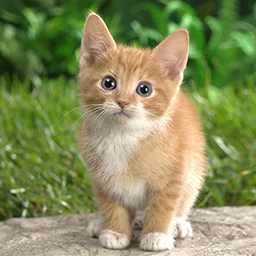

In [0]:
image = get_cat_image()
show_image(image)
# Convert image to a format the model can understand.
image = convert_image(image)

Then, we grab a relay function containing ResNet, along with its static parameters.


In [0]:
resnet, params = get_resnet()
print(resnet)
print()
pprint.pprint(list(params.keys()))

v0.0.1
fn (%data: Tensor[(1, 3, 224, 224), float32], %resnetv10_conv0_weight: Tensor[(64, 3, 7, 7), float32], %resnetv10_batchnorm0_gamma: Tensor[(64,), float32], %resnetv10_batchnorm0_beta: Tensor[(64,), float32], %resnetv10_batchnorm0_running_mean: Tensor[(64,), float32], %resnetv10_batchnorm0_running_var: Tensor[(64,), float32], %resnetv10_stage1_conv0_weight: Tensor[(64, 64, 3, 3), float32], %resnetv10_stage1_batchnorm0_gamma: Tensor[(64,), float32], %resnetv10_stage1_batchnorm0_beta: Tensor[(64,), float32], %resnetv10_stage1_batchnorm0_running_mean: Tensor[(64,), float32], %resnetv10_stage1_batchnorm0_running_var: Tensor[(64,), float32], %resnetv10_stage1_conv1_weight: Tensor[(64, 64, 3, 3), float32], %resnetv10_stage1_batchnorm1_gamma: Tensor[(64,), float32], %resnetv10_stage1_batchnorm1_beta: Tensor[(64,), float32], %resnetv10_stage1_batchnorm1_running_mean: Tensor[(64,), float32], %resnetv10_stage1_batchnorm1_running_var: Tensor[(64,), float32], %resnetv10_stage1_conv2_weight: 

With that, we can create a μTVM session, build a graph runtime module, then run the model.

In [0]:
with micro.Session(device_type='host', binutil_prefix='') as sess:
  module, params = sess.build(resnet, params=params)
  module.set_input(**params)
  # Execute with `image` as the input.
  module.run(data=image)
  print(get_prediction(module))

v0.0.1
fn (%data: Tensor[(1, 3, 224, 224), float32], %resnetv10_conv0_weight: Tensor[(64, 3, 7, 7), float32], %resnetv10_batchnorm0_gamma: Tensor[(64,), float32], %resnetv10_batchnorm0_beta: Tensor[(64,), float32], %resnetv10_batchnorm0_running_mean: Tensor[(64,), float32], %resnetv10_batchnorm0_running_var: Tensor[(64,), float32], %resnetv10_stage1_conv0_weight: Tensor[(64, 64, 3, 3), float32], %resnetv10_stage1_batchnorm0_gamma: Tensor[(64,), float32], %resnetv10_stage1_batchnorm0_beta: Tensor[(64,), float32], %resnetv10_stage1_batchnorm0_running_mean: Tensor[(64,), float32], %resnetv10_stage1_batchnorm0_running_var: Tensor[(64,), float32], %resnetv10_stage1_conv1_weight: Tensor[(64, 64, 3, 3), float32], %resnetv10_stage1_batchnorm1_gamma: Tensor[(64,), float32], %resnetv10_stage1_batchnorm1_beta: Tensor[(64,), float32], %resnetv10_stage1_batchnorm1_running_mean: Tensor[(64,), float32], %resnetv10_stage1_batchnorm1_running_var: Tensor[(64,), float32], %resnetv10_stage1_conv2_weight: 

TVMError: ignored

# Homework: RISC-V

To use RISC-V as a target device, there are some extra steps that can't be done within this notebook.

First, you will need to download and compile [TVM](https://github.com/dmlc/tvm) on your own machine.

Next, you will need [Spike](https://github.com/riscv/riscv-isa-sim) (a RISC-V ISA simulator) and [OpenOCD](https://github.com/ntfreak/openocd) (provides a high-level debugging interface to compatible devices).

TODO: Flesh out.

# Additional Resources

For more details on how μTVM is implemented, you can look into the following pull requests on the [TVM GitHub](https://github.com/dmlc/tvm) repository: 

- [C code generation backend](https://github.com/dmlc/tvm/pull/2161)
- [μTVM on host-emulated device](https://github.com/dmlc/tvm/pull/3227)
- μTVM on RISC-V: TODO ??
- [μTVM RFC](https://github.com/dmlc/tvm/issues/2563) (somewhat outdated)



